* 2022-12-14 This version fixes a bug where "get_alpha_nboots()" was defined but it was  "_get_alpha_nboots()" that was was mistakenly invoked.

# This First Part is from "How To Deal With Imbalanced Classification, Without Re-balancing the Data"  by David Rosen 

https://towardsdatascience.com/how-to-deal-with-imbalanced-classification-without-re-balancing-the-data-8a3c02353fe3
## Second Part is down below

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics, model_selection
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
df=pd.read_csv('creditcard.csv')
df.info()

C:\Users\926304897\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [2]:
df.Class.sum(),df.Class.mean()

(492, 0.001727485630620034)

## split into train and test and train the model

In [3]:
Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(
        df.loc[:,'V1':'Amount'], df.Class,  stratify=df.Class, 
        test_size=0.3, random_state=42)
gbc=HistGradientBoostingClassifier(learning_rate=0.01, 
        max_iter=2000, max_leaf_nodes=6, validation_fraction=0.2, 
        n_iter_no_change=15, random_state=42).fit(Xtrain,ytrain)

In [4]:
[type(x) for x in (Xtrain, Xtest, ytrain, ytest)]

[pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.series.Series,
 pandas.core.series.Series]

In [5]:
ytrain,ytest

(249927    0
 214082    0
 106005    0
 58619     0
 191638    0
          ..
 3441      0
 233802    0
 85418     0
 29062     0
 17677     0
 Name: Class, Length: 199364, dtype: int64,
 186882    0
 165754    0
 235285    0
 101271    0
 5832      0
          ..
 64725     0
 16688     0
 183868    0
 45011     0
 150527    0
 Name: Class, Length: 85443, dtype: int64)

## apply the full model to the test data as a hard classifier with (implicit) decision threshold 0.5

In other words, this classifier tells us which class is more probable than the other according to the model

In [6]:
hardpredtst=gbc.predict(Xtest)
def conf_matrix(y,pred):
    ((tn, fp), (fn, tp)) = metrics.confusion_matrix(y, pred)
    ((tnr,fpr),(fnr,tpr))= metrics.confusion_matrix(y, pred, 
            normalize='true')
    return pd.DataFrame([[f'TN = {tn} (TNR = {tnr:1.2%})', 
                                f'FP = {fp} (FPR = {fpr:1.2%})'], 
                         [f'FN = {fn} (FNR = {fnr:1.2%})', 
                                f'TP = {tp} (TPR = {tpr:1.2%})']],
            index=['True 0(Legit)', 'True 1(Fraud)'], 
            columns=['Pred 0(Approve as Legit)', 
                            'Pred 1(Deny as Fraud)'])
display(conf_matrix(ytest,hardpredtst))

,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 85285 (TNR = 99.99%),FP = 10 (FPR = 0.01%)
True 1(Fraud),FN = 42 (FNR = 28.38%),TP = 106 (TPR = 71.62%)


The true pos rate (Recall of class 1 (frauds)) is too low -- we want to identify more than 72% of frauds as such

Ultimately it is a business decision what threshold to apply when deciding whether to approve a transaction, as it is a trade-off between false approvals and false rejections.

## plot the true positive rate and false positive rate as a function of threshold to manage the trade-off

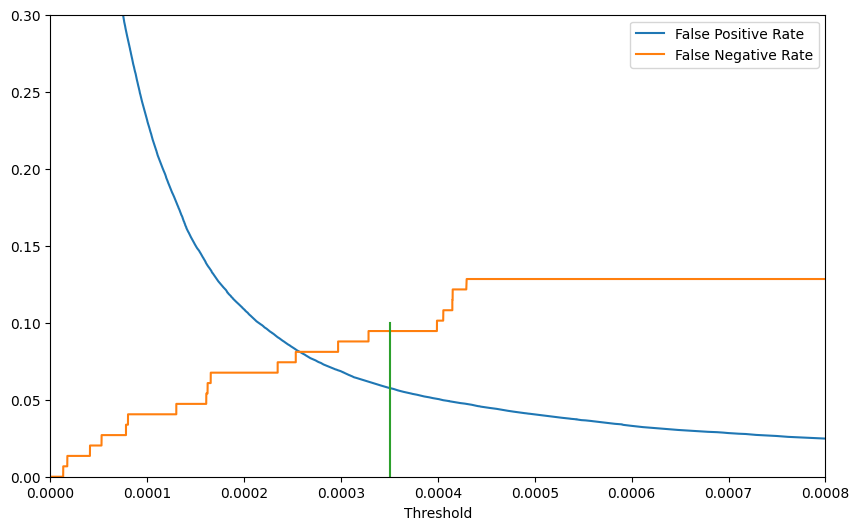

In [7]:
predtst=gbc.predict_proba(Xtest)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(ytest, predtst)
dfplot=pd.DataFrame({'Threshold':thresholds, 
        'False Positive Rate':fpr, 
        'False Negative Rate': 1.-tpr})
ax=dfplot.plot(x='Threshold', y=['False Positive Rate',
        'False Negative Rate'], figsize=(10,6))
ax.plot([0.00035,0.00035],[0,0.1]) #mark example thresh.
ax.set_xbound(0,0.0008); ax.set_ybound(0,0.3) #zoom in

## choose a threshold of 0.00035 (0.035%) (vertical green line shown) which will give us a false negative (approved fraud) rate of about 9% and a false positive (rejected legitimate) rate of about 6%

In [8]:
hardpredtst_tuned_thresh = np.where(predtst >= 0.00035, 1, 0)
conf_matrix(ytest, hardpredtst_tuned_thresh)

,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 80388 (TNR = 94.25%),FP = 4907 (FPR = 5.75%)
True 1(Fraud),FN = 14 (FNR = 9.46%),TP = 134 (TPR = 90.54%)


Sure enough, False neg rate of 9.46% (i.e. identified/denied 90.54% of our frauds) and false pos rt of 5.75% (i.e. still approved 94.25% of our legitimate transactions).

# This second part is for "How to calculate Machine Learning confidence intervals using an automatic bootstrap method”

## custom metric specificity_score(), and a function to apply a list of metrics to data

In [9]:
import re  # regular expressions
import numpy as np
import pandas as pd
from sklearn import metrics
def specificity_score(true, pred, **kwargs):
    """sklearn-compat Specificity metric func for binary: 1=posi class, 0=nega
    """
    return metrics.recall_score(1 - pd.Series(true), 1 - pd.Series(pred), **kwargs)
specificity_score.__name__ = "Specificity (Recall of −ve)"
def calc_metrics(metrics, *data_args):
    """Return a list of calculated values for each metric applied to *data_args
    where metrics is a metric func or iterable of funcs e.g. [m1, m2, m3, m4]
    """
    metrics=_fix_metrics(metrics)
    mname = metrics.__name__ if hasattr(metrics, '__name__') else "Metric"
    return pd.Series\
      ([m(*data_args) for m in metrics], index=[_metric_name(m) for m in metrics], name=mname)
def _metric_name(metric):  # use its prettified __name__
    name = re.sub(' score$', '', metric.__name__.replace('_',' ').strip())
    return name.title() if name.lower()==name else name
def _fix_metrics(metrics_): # allow for single metric func or any iterable of metric funcs
    if callable(metrics_): metrics_=[metrics_]  # single metric func to list of one
    return pd.Series(metrics_)  # in case iterable metrics_ is generator, generate & store them

## make a list of metrics and apply them to the data

In [10]:
met=[ metrics.recall_score, specificity_score, 
      metrics.balanced_accuracy_score
    ]
calc_metrics(met, ytest, hardpredtst_tuned_thresh)

Recall                         0.905405
Specificity (Recall of −ve)    0.942470
Balanced Accuracy              0.923938
Name: Metric, dtype: float64

## Function to make 1 boot dataset

In [11]:
def one_boot(*data_args):
    """Usage: (t, p) = one_boot(true, pred) with true, pred, t, p arrays of same length
    """
    length = len(data_args[0])
    index = np.random.randint(0, length, size=length)  # apply same sampled index to all args:
    return [ pd.Series(arg.values[index], name=arg.name)  # .reset_index() is slower
             if isinstance(arg, pd.Series) else arg[index]   for  arg in data_args
           ]

## show 1 boot dataset next to orig dataset

In [12]:
%%script echo skipping
ytest=ytest.reset_index(drop=True)
np.random.seed(13)
(y,pred) = one_boot(ytest, hardpredtst_tuned_thresh)
pd.DataFrame\
  (dict(ytest=ytest, hardpredtst_tuned_thresh=hardpredtst_tuned_thresh, y=y, pred=pred))

Couldn't find program: 'echo'


## Making each boot sample dataset and calculating metrics for it

In [13]:
import tqdm  # progress bar
def trange(iterable):  # narrower progress bar so it won't wrap
    return tqdm.trange(iterable, bar_format="{l_bar}{bar:30}{r_bar}{bar:-10b}")
def raw_metric_samples(metrics, *data_args, nboots):
    """Return dataframe containing metric(s) for nboots boot sample datasets
    where metrics is a metric func or iterable of funcs e.g. [m1, m2, m3]
    """
    metrics=_fix_metrics(metrics)
    cols=[ calc_metrics(metrics, *boot_data)   for boot_data  in _boot_generator\
           (*data_args, nboots=nboots)  if boot_data[0].nunique() > 1  # > 1 for log Loss, ROC
         ]#end of list comprehension
    return pd.DataFrame\
      ( {iboot: col for iboot,col in enumerate(cols)}#end of dict comprehension
      ).rename_axis("Boot", axis="columns").rename_axis(cols[0].name)
def _boot_generator(*data_args, nboots): # return Gener of boot sample datasets, not huge list!
    return (one_boot(*data_args) for _ in trange(nboots)) # generator expression

## Look at metrics on 7 boot sample datasets

In [14]:
np.random.seed(13)
raw_metric_samples(met, ytest, hardpredtst_tuned_thresh, 
          nboots=7).style.format('{:.2%}')  #optional #style

100%|██████████████████████████████| 7/7 [00:00<00:00, 16.17it/s]                                                                                          


Boot,0,1,2,3,4,5,6
Metric,,,,,,,
Recall,93.46%,89.81%,96.62%,89.38%,89.57%,89.68%,82.82%
Specificity (Recall of −ve),94.29%,94.14%,94.29%,94.35%,94.27%,94.09%,94.28%
Balanced Accuracy,93.88%,91.98%,95.45%,91.86%,91.92%,91.88%,88.55%


## Functions to calculate default nboots as min needec for given alpha, smallest alpha that we can calculate accurately for "small" specified nboots.

In [15]:
DFLT_ALPHA = 0.05  # 95% confidence level.    # MIN_BOOTS_IN_1TAIL includes tail boundary:
MIN_BOOTS_IN_1TAIL=11 # North et al.:10; Davidson&MacK ".05-->399"==>11, ".01-->1499"==>9
MAX_ALPHA = 0.40 # Make it .25 or .20?  Min boots formula dubious even at .40 or .25?

# Formula: boots_in_1tail = (nboots - 1) * (0.5*alpha) + 1 ; (0.5*alpha is size of 1 tail)
# E.g. nboots=6, alpha=0.40 (confid level = .60). With vals X[0] to X[5] sorted, quantiles are:
#   0.0 --> X[0]  (first of 2 in lower tail)
#   0.2 --> X[1]  interval lower  (0.5*alpha gives 0.2) (2nd of 2 in lower tail)
#   0.4 --> X[2]
#   0.6 --> X[3]
#   0.8 --> X[4]  interval upper  (1 - 0.5*alpha gives 0.8) (2nd of 2 in upper tail)
#   1.0 --> X[5]  (first of 2 in upper tail)
# so boots_in_1tail is (6-1)0.5*0.40+1 gives 2 per tail: X[0],X[1] in lower, X[4],X[5] in upper
def _min_nboots_from(alpha): # Calculate using this formula (from abov), solved for min_nboots: 
                             # MIN_BOOTS_IN_1TAIL = (min_nboots - 1) * (0.5*alpha) + 1
    return int(np.ceil((MIN_BOOTS_IN_1TAIL - 1)/(0.5*alpha) + 1)) 
def _min_alpha_from(nboots): # Calc. using this formula (from above), but solved for min_alpha: 
                             # MIN_BOOTS_IN_1TAIL = (nboots - 1) * (0.5*min_alpha) + 1
    return 2 * (MIN_BOOTS_IN_1TAIL - 1) / (nboots - 1)
MIN_NBOOTS = _min_nboots_from(MAX_ALPHA)

def get_alpha_nboots(alpha=DFLT_ALPHA, nboots=None):
    """Return (alpha, nboots) with default nboots, applying MIN_NBOOTS and min alpha for nboots.
    """
    if alpha > MAX_ALPHA and (0 < (1-alpha) <= MAX_ALPHA):
        raise ValueError(f'alpha={alpha} > {MAX_ALPHA}. Did you mean alpha={1-alpha:.9g}?')
    elif not (0 < alpha <= MAX_ALPHA):
        raise ValueError(f'alpha={alpha} is outside allowed range: 0 < alpha <= {MAX_ALPHA}')
    if pd.isna(nboots):   # by dflt use calculated min nboots for given alpha:
        nboots = _min_nboots_from(alpha)
    if int(nboots) != nboots: raise ValueError(f"nboots={nboots} isn't an integer")
    nboots = max(int(nboots), MIN_NBOOTS)  # apply min to a specified OR calcul./default nboots
    return (max(alpha, _min_alpha_from(nboots)), nboots)  # apply min alpha for final nboots

In [16]:
g = get_alpha_nboots 
pd.DataFrame( [ g(0.40), g(0.20, None), g(0.10), g(), g(alpha=0.02), 
                g(alpha=0.01, nboots=None), g(0.005, nboots=None)
              ], columns=['alpha', 'default nboots']
            ).set_index('alpha')

,default nboots
alpha,
0.400,51
0.200,101
0.100,201
0.050,401
0.020,1001
0.010,2001
0.005,4001


In [17]:
req=[(0.01,3000), (0.01,401), (0.01,2)]
out=[get_alpha_nboots(*args) for args in req]
mydf = lambda x: pd.DataFrame(x, columns=['alpha', 'nboots'])
pd.concat([mydf(req),mydf(out)],axis=1, keys=('Requested','Using'))

Requested        Using       
      alpha nboots alpha nboots
0      0.01   3000  0.01   3000
1      0.01    401  0.05    401
2      0.01      2  0.40     51

## Histogram of Balanced Accuracy on bootstrap sample datasets, showing confidence interval

In [18]:
import matplotlib, matplotlib.ticker as mtick
def metric_boot_histogram(metric, *data_args, alpha=DFLT_ALPHA, nboots=None):
    """Plot histogram w/ lines for 1 observed metric & its confidence interval.
    """
    alpha, nboots = get_alpha_nboots(alpha, nboots) # 1-row df 2 series:
    series = raw_metric_samples(metric, *data_args, nboots=nboots).iloc[0,:]
    nboots=len(series) # in case some failed
    (lo, hi) = series.quantile([0.5*alpha, 1 - 0.5*alpha])
    matplotlib.rcParams["figure.dpi"] = 250
    ax = series.hist(bins=50, figsize=(7, 2.5), alpha=0.4, edgecolor='white')
    showing = f", showing {100*(1-alpha):.4g}% Confidence Interval"
    ax.set_title(f"Histogram of {nboots} boot results" + showing)
    ax.set_xlabel(series.name)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
    for x in lo, metric(*data_args), hi:
        ax.plot([x, x], [0, nboots*.07], lw=2.5)

100%|██████████████████████████████| 401/401 [00:04<00:00, 94.92it/s]                                                                                      


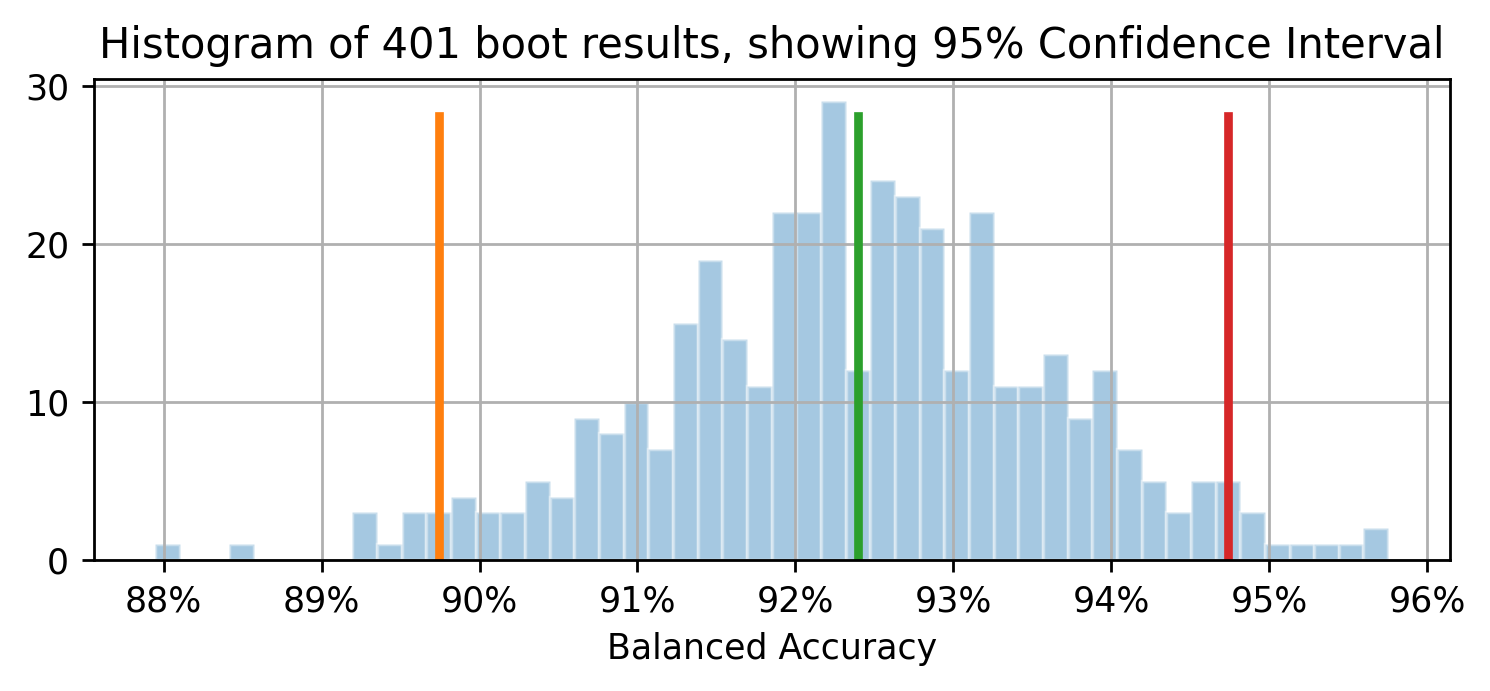

In [19]:
np.random.seed(13)
metric_boot_histogram\
  (metrics.balanced_accuracy_score, ytest, hardpredtst_tuned_thresh)

## How to calculate the confidence intervals for list of metrics

In [20]:
def ci_auto( metrics, *data_args, alpha=DFLT_ALPHA, nboots=None):
    """Return Pandas data frame of bootstrap confidence intervals. 
    PARAMETERS:
    metrics : a metric func or iterable of funcs e.g. [m1, m2, m3]
    data_args : 1+ (often 2, e.g. ytrue,ypred) iterables for metric 
    alpha: = 1 - confidence level; default=0.05 i.e. confidence=0.95
    nboots (optional!): # boots drawn from data; dflt None ==> calc. from alpha
    """
    alpha, nboots = get_alpha_nboots(alpha, nboots)
    metrics=_fix_metrics(metrics)
    result=raw_metric_samples(metrics, *data_args, nboots=nboots)
    nb=result.shape[1]  # num boots we ended up with
    if nb<nboots:
        t = f'Note: {nboots-nb} boot sample datasets dropped\n'
        print(t + f'(out of {nboots}) because all vals were same in 1st data arg.')
    result = result.apply(lambda row: row.quantile([0.5*alpha, 1 - 0.5*alpha]), axis=1)
    result.columns = [f'{x*100:.4g}%ile' for x in (0.5*alpha, 1 - 0.5*alpha)]
    result.insert(0, "Observed", calc_metrics(metrics, *data_args)) # col. for obs (point estim)
    return result.rename_axis(f"%ile for {nb} Boots", axis="columns")

## Calculate the results!

In [21]:
np.random.seed(13)
ci_auto( met, ytest, hardpredtst_tuned_thresh
       ).style.format('{:.2%}')

100%|██████████████████████████████| 401/401 [00:22<00:00, 18.22it/s]                                                                                      


%ile for 401 Boots,Observed,2.5%ile,97.5%ile
Metric,,,
Recall,90.54%,85.29%,95.27%
Specificity (Recall of −ve),94.25%,94.11%,94.40%
Balanced Accuracy,92.39%,89.74%,94.74%


In [22]:
#############################################################################79
###############################################################################################97